In [1]:
import torch
import math
import gc
import os.path as osp
from utils import *
from args import *
from dataset import *
from tqdm import tqdm
from torch_geometric.loader import DataLoader
from model import load_model

import ase.io
from ase.io import read as ase_read

/root/anaconda3/envs/material/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_folder = "PNA/1720343668248499"

In [3]:
@torch.no_grad()
def predict_step(model, data, predict_epochs, device):
    model.eval()

    pbar = tqdm(total=predict_epochs)
    pbar.set_description("Predicting")

    with torch.no_grad():
        res_out = torch.zeros(0).to(device)
        idx_out = torch.zeros(0).to(device)
        for i, d in enumerate(data):
            d = d.to(device)
            out = model(d)
            res_out = torch.cat((res_out, out), 0)
            idx_out = torch.cat((idx_out, d.id))
            pbar.update(1)
        pbar.close()

    return res_out, idx_out

In [ ]:
device = get_device()

# load model from file
model_path = osp.join(args["result_path"], model_folder)
model, _ = load_model(model_path, file_name="checkpoint.pt", load_dict=True)

# get hypothesis dataset
hypo_dataset = HypoDataset(args)

# Change batch_size according your device performance
batch_size = 1000

full_out = torch.zeros(0).to(device)
idx_out = torch.zeros(0).to(device)
for i, dataset in enumerate(hypo_dataset):
    data_length = len(dataset)
    predict_epochs = math.ceil(data_length / batch_size)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    out, idx = predict_step(model, dataloader, predict_epochs, device)
    full_out = torch.cat((full_out, out), 0)
    idx_out = torch.cat((idx_out, idx), 0)

    del out, idx, dataset, dataloader
    torch.cuda.empty_cache()
    gc.collect()

# reverse data scale
min, max = get_data_scale(args)
print(min, max)
get_out = reverse_min_max_scalar_1d(full_out, min, max)
print(len(get_out))

Save 1G predicts

In [5]:
torch.save((get_out, idx_out), osp.join(model_path, "1G_predict.pt"))

Load Model

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import torch

get_out, idx_out = torch.load(osp.join(args["result_path"], f"{model_folder}/1G_predict.pt"))

In [5]:
print(len(get_out))

1254570


total: 1254570
Ef<0: 454152
Ef>0: 800416
ratio of Ef<0  0.36199813481910137


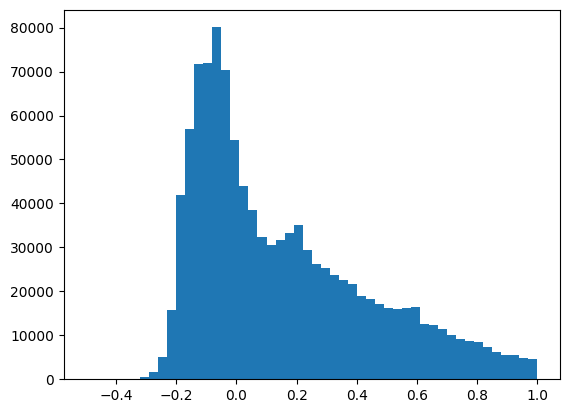

In [6]:
# show results
plt.hist(get_out.to("cpu"), range=(-0.5, 1.0), bins=50)
# plt.savefig(fname=osp.join(model_path, "1G_predict_distribution.png"))

get_out_np = get_out.to("cpu").numpy()
print("total:", len(get_out_np))
print("Ef<0:", len(get_out_np[get_out_np < 0.0]))
print("Ef>0:", len(get_out_np[get_out_np > 0.0]))
print("ratio of Ef<0 ", len(get_out_np[get_out_np < 0.0]) / len(get_out_np))

Extract Data

In [7]:
# get_out < 0.0 random 1%
ratio = 0.01
random_seed = 114514

extract_out = get_out_np < 0.0
extract_out_idx = np.where(extract_out)[0]

np.random.seed(random_seed)
extract_out_random_idx = np.random.choice(extract_out_idx, round(len(extract_out_idx) * ratio), replace=False)
extract_out_random_idx.sort()
random_idx = extract_out_random_idx

print(random_idx)
print(len(random_idx))

[   1703    2579    3046 ... 1254048 1254208 1254546]
4542


In [8]:
# get ase data block
hypo_dataset = HypoDataset(args)

last_idx = 0
current_idx = 0

idx_list = []
data_list = []
vasp_list = []
pred_list = []
for i in range(len(hypo_dataset)):
    data_block = hypo_dataset.get(i, False)
    # if len(data_block) != len(vasp_block):
    #     print("something wrong")

    last_idx = current_idx
    current_idx += len(data_block)
    print(last_idx, current_idx)

    # random_idx + 1 is ID.
    item = random_idx[np.where((random_idx >= last_idx) & (random_idx < current_idx))[0]]

    for d in item:
        data_list.append(data_block[d - last_idx])
    del data_block
    
    vasp_block = hypo_dataset.get(i, True)
    for d in item:
        vasp_list.append(vasp_block[d - last_idx])
    del vasp_block
    
    for d in item:
        idx_list.append(d)
        pred_list.append(get_out_np[d])

print(len(idx_list))
print(len(data_list))
print(len(vasp_list))

0 125430
125430 250860
250860 376290
376290 501720
501720 627150
627150 752580
752580 878010
878010 1003440
1003440 1128870
1128870 1254570
4542
4542
4542


In [17]:
for i, d in zip(idx_list, vasp_list):
    if not i == d[0] - 1:
        print("something wrong")

data = {"data_list": data_list, "vasp_list": vasp_list, "idx_list": idx_list, "pred_list": pred_list, "random_seed": random_seed}
torch.save(data, osp.join(args["result_path"], f"{model_folder}/sample_data.pt"))

In [19]:
data = torch.load(osp.join(args["result_path"], f"{model_folder}/sample_data.pt"))
for i, d in enumerate(data["vasp_list"]):
    with open(f"./sample_data/CONFIG_{i+1}.poscar", "w") as file:
        file.write(d[1].getvalue())

# if data["pred_list"][i] >= 0.0:
#     print("something wrong")

---

In [10]:
a = hypo_dataset[0]

In [90]:
# for i in range(0, 30):
#     print(a[i])

# 78871

a_idx = 78871
print(a[a_idx - 1])
print(a[a_idx - 1].edge_index[0][0].type())
print(torch.argmax(a[a_idx - 1].x, dim=1))
print(a[a_idx - 1].edge_attr)

Data(edge_index=[2, 254], edge_attr=[254, 1], x=[30, 84], id=78871)
torch.LongTensor
tensor([53, 53, 24, 24, 24, 24, 24, 24, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22,
        22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22])
tensor([[2.9866],
        [3.5697],
        [3.5697],
        [3.8857],
        [3.2135],
        [3.2135],
        [3.2135],
        [3.2135],
        [3.8857],
        [3.5697],
        [3.5697],
        [2.9866],
        [2.7618],
        [2.7848],
        [2.7922],
        [2.7710],
        [2.7748],
        [2.7618],
        [2.7848],
        [2.7922],
        [2.7710],
        [2.7748],
        [2.7642],
        [2.7859],
        [2.7919],
        [2.7859],
        [2.7642],
        [2.7642],
        [2.7859],
        [2.7919],
        [2.7859],
        [2.7642],
        [2.7748],
        [2.7710],
        [2.7922],
        [2.7848],
        [2.7618],
        [2.7748],
        [2.7710],
        [2.7922],
        [2.7848],
        [2.7618],
        [2.9866],
    

In [104]:
# 2630 2631
mp_idx = 2630
mp = MPDataset(args)
print(mp[mp_idx - 1])
print(mp[mp_idx - 1].x.type())
print(torch.argmax(mp[mp_idx - 1].x, dim=1))
print(mp[mp_idx - 1].edge_attr)

Data(mid='mp-753942', idx='2630', edge_index=[2, 254], edge_weight=[254], y=[1], edge_attr=[254, 1], x=[30, 84])
torch.FloatTensor
tensor([51, 51, 34, 34, 34, 34, 34, 34, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
        30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30])
tensor([[3.0275],
        [3.6186],
        [3.6186],
        [3.9389],
        [3.2575],
        [3.2575],
        [3.2575],
        [3.2575],
        [3.9389],
        [3.6186],
        [3.6186],
        [3.0275],
        [2.7996],
        [2.8229],
        [2.8305],
        [2.8089],
        [2.8128],
        [2.7996],
        [2.8229],
        [2.8305],
        [2.8089],
        [2.8128],
        [2.8021],
        [2.8241],
        [2.8301],
        [2.8241],
        [2.8021],
        [2.8021],
        [2.8241],
        [2.8301],
        [2.8241],
        [2.8021],
        [2.8128],
        [2.8089],
        [2.8305],
        [2.8229],
        [2.7996],
        [2.8128],
        [2.8089],
        [2.8305],
        [2.8

------------

In [12]:
import torch
import matplotlib.pyplot as plt

import time

import os.path as osp
import numpy as np

from dataset import make_dataset
from train import make_data_loader, train_step, test_evaluations
from utils import get_device, plot_training_progress
from model import GCNNetwork, CEALNetwork

from args import *
from utils import *

from tqdm import tqdm
from IPython.display import clear_output as ipyclear

In [32]:
train_dataset, validation_dataset, test_dataset = make_dataset()
train_loader, val_loader, test_loader = make_data_loader(train_dataset, validation_dataset, test_dataset)

In [39]:
validation_dataset[0].y

tensor([0.4008])

1
tensor([0.2934, 0.3827, 0.6370, 0.3749, 0.4103, 0.2883, 0.2598, 0.3871, 0.3728,
        0.4696, 0.4369, 0.3786, 0.1858, 0.3566, 0.4555, 0.4332, 0.4179, 0.5325,
        0.4590, 0.4249, 0.3717, 0.3682, 0.4871, 0.4141, 0.4624, 0.3639, 0.3540,
        0.4132, 0.3001, 0.4143, 0.3946, 0.3796, 0.3701, 0.3836, 0.4612, 0.4105,
        0.3528, 0.0205, 0.2810, 0.3966, 0.4367, 0.1686, 0.6091, 0.2977, 0.3994,
        0.3000, 0.3993, 0.5133, 0.3920, 0.3101, 0.3333, 0.4516, 0.4382, 0.3770,
        0.4189, 0.2982, 0.4256, 0.3033, 0.4372, 0.4280, 0.3560, 0.2070, 0.3927,
        0.5616, 0.3948, 0.4118, 0.4339, 0.2695, 0.4257, 0.6642, 0.3657, 0.4170,
        0.4627, 0.4101, 0.3133, 0.3859, 0.3650, 0.9250, 0.4732, 0.3538, 0.5595,
        0.2905, 0.4565, 0.4511, 0.4393, 0.3535, 0.4245, 0.6164, 0.2049, 0.4177,
        0.4120, 0.3871, 0.3880, 0.2245, 0.4109, 0.4113, 0.4420, 0.2381, 0.4613,
        0.4093, 0.4113, 0.2641, 0.4367, 0.6314, 0.4223, 0.3564, 0.3800, 0.2931,
        0.5607, 0.1466, 0.3278, 0.4400

(array([0.000e+00, 0.000e+00, 1.000e+00, 1.400e+01, 2.300e+01, 3.100e+01,
        2.300e+01, 3.600e+01, 3.100e+01, 9.000e+01, 1.210e+02, 9.800e+01,
        1.010e+02, 1.130e+02, 1.450e+02, 1.830e+02, 1.730e+02, 2.090e+02,
        2.620e+02, 3.910e+02, 6.610e+02, 1.055e+03, 1.367e+03, 1.206e+03,
        6.900e+02, 4.870e+02, 2.160e+02, 5.600e+01, 7.500e+01, 4.900e+01,
        6.100e+01, 3.600e+01, 4.600e+01, 5.700e+01, 4.100e+01, 2.600e+01,
        3.000e+01, 2.500e+01, 1.500e+01, 1.400e+01, 1.900e+01, 1.600e+01,
        1.500e+01, 1.000e+01, 1.300e+01, 1.200e+01, 6.000e+00, 7.000e+00,
        3.000e+00, 2.000e+00]),
 array([-5.        , -4.80000019, -4.5999999 , -4.4000001 , -4.19999981,
        -4.        , -3.79999995, -3.5999999 , -3.4000001 , -3.20000005,
        -3.        , -2.79999995, -2.5999999 , -2.4000001 , -2.20000005,
        -2.        , -1.79999995, -1.60000002, -1.39999998, -1.20000005,
        -1.        , -0.80000001, -0.60000002, -0.40000001, -0.2       ,
         0.

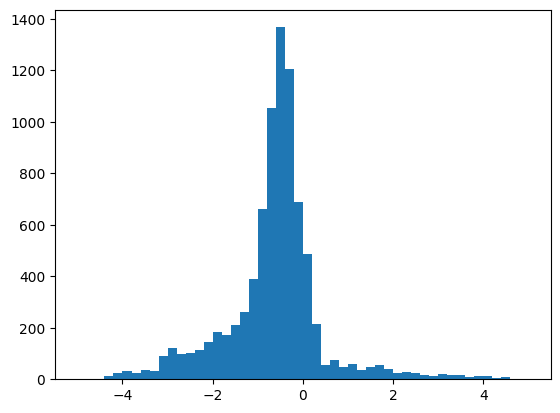

In [33]:
test_loss, test_out, test_y = test_evaluations(model, test_loader, test_dataset, device, ret_data=True)
test_out = reverse_min_max_scalar_1d(test_out, min, max)
test_y = reverse_min_max_scalar_1d(test_y, min, max)
loss = (test_out.squeeze() - test_y).abs().mean()

plt.hist(test_y.to("cpu"), range=(-5, 5), bins=50)